# Translation ecoder-decocer with attention over the b5 dataset

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.ticker as ticker
from torchtext import data
import pandas as pd
import unicodedata
import string
import re
import random
import copy
from contra_qa.plots.functions  import simple_step_plot
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from nltk.translate.bleu_score import sentence_bleu

% matplotlib inline

### Preparing data

In [2]:
df2 = pd.read_csv("data/boolean5_train.csv")
df2_test = pd.read_csv("data/boolean5_test.csv")


df2["text"] = df2["sentence1"] + df2["sentence2"] 
df2_test["text"] = df2_test["sentence1"] + df2_test["sentence2"] 

all_sentences = list(df2.text.values) + list(df2_test.text.values)

df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]

In [3]:
df2train.tail()

,sentence1,sentence2,and_A,and_B,label,text
8495,Roland created a shy and wonderful work of art,Roland didn't create a delightful work of art,Roland created a shy work of art,Roland created a wonderful work of art,0,Roland created a shy and wonderful work of art...
8496,Tracy created a powerful and stocky work of art,Samantha didn't create a powerful work of art,Tracy created a powerful work of art,Tracy created a stocky work of art,0,Tracy created a powerful and stocky work of ar...
8497,Joann created a repulsive and flabby work of art,Joann didn't create a polite work of art,Joann created a repulsive work of art,Joann created a flabby work of art,0,Joann created a repulsive and flabby work of a...
8498,Joshua created a jolly and black work of art,Joshua didn't create a jolly work of art,Joshua created a jolly work of art,Joshua created a black work of art,1,Joshua created a jolly and black work of art J...
8499,Alison created an ashy and helpful work of art,Alison didn't create a pitiful work of art,Alison created an ashy work of art,Alison created a helpful work of art,0,Alison created an ashy and helpful work of art...


In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


example = "Sheryl went to cluj-Napoca and Hunedoara"
print("Before:", example)
print()
print("After:", normalizeString(example))

Before: Sheryl went to cluj-Napoca and Hunedoara

After: sheryl went to cluj napoca and hunedoara


In [6]:
pairs_A = list(zip(list(df2train.sentence1.values), list(df2train.and_A.values)))
pairs_B = list(zip(list(df2train.sentence1.values), list(df2train.and_B.values)))
pairs_A = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A]
pairs_B = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B]
pairs_A_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_A.values)))
pairs_B_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_B.values)))
pairs_A_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A_val]
pairs_B_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B_val]


In [7]:
all_text_pairs = zip(all_sentences, all_sentences)
all_text_pairs = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in all_text_pairs]

In [8]:
def readLangs(lang1, lang2, pairs, reverse=False):
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [tuple(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [9]:
f = lambda x: len(x.split(" "))

MAX_LENGTH = np.max(list(map(f, all_sentences)))

In [10]:
MAX_LENGTH = 20


def filterPair(p):
    cond1 = len(p[0].split(' ')) < MAX_LENGTH
    cond2 = len(p[1].split(' ')) < MAX_LENGTH 
    return cond1 and cond2


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [11]:
def prepareData(lang1, lang2, pairs, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [12]:
all_text_pairs[0]

('jeffery created a silly and vast work of art jeffery didn t create a silly work of art',
 'jeffery created a silly and vast work of art jeffery didn t create a silly work of art')

In [13]:
_, _, training_pairs_A = prepareData("eng_enc",
                                     "eng_dec",
                                     pairs_A)
print()


input_lang, _, _ = prepareData("eng_enc",
                               "eng_dec",
                               all_text_pairs)

output_lang = copy.deepcopy(input_lang)

print()

_, _, valid_pairs_A = prepareData("eng_enc",
                                "eng_dec",
                                pairs_A_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 773
eng_dec 772

Read 11000 sentence pairs
Trimmed to 11000 sentence pairs
Counting words...
Counted words:
eng_enc 776
eng_dec 776

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 701
eng_dec 700


In [14]:
_, _, training_pairs_B = prepareData("eng_enc",
                                     "eng_dec",
                                     pairs_B)
print()
_, _, valid_pairs_B = prepareData("eng_enc",
                                "eng_dec",
                                pairs_B_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 773
eng_dec 772

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 701
eng_dec 700


In [15]:
# all_sentences_1_and_2 = list(df2.sentence1.values) + list(df2.sentence2.values) + list(df2_test.sentence1.values) + list(df2_test.sentence2.values) 

# f = lambda x: len(x.split(" "))

# MAX_LENGTH = np.max(list(map(f, all_sentences_1_and_2))) + 1

### sentences 2 tensors

In [16]:
example = random.choice(training_pairs_A)
print(example)

('raul created an unsightly and famous work of art', 'raul created an unsightly work of art')


In [17]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [18]:
indexesFromSentence(input_lang,example[0])

[662, 3, 18, 117, 6, 114, 8, 9, 10]

In [19]:
indexesFromSentence(output_lang, example[1])

[662, 3, 18, 117, 8, 9, 10]

In [20]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [21]:
input_sen = tensorFromSentence(input_lang,example[0])
output_sen = tensorFromSentence(output_lang, example[1])

print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

tensor([[662],
        [  3],
        [ 18],
        [117],
        [  6],
        [114],
        [  8],
        [  9],
        [ 10],
        [  1]])

torch.Size([10, 1])
torch.int64
tensor([[662],
        [  3],
        [ 18],
        [117],
        [  8],
        [  9],
        [ 10],
        [  1]])

torch.Size([8, 1])
torch.int64


In [22]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [23]:
input_sen, output_sen = tensorsFromPair(example)


print("input\n")
print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)

print("\noutput\n")
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

input

tensor([[662],
        [  3],
        [ 18],
        [117],
        [  6],
        [114],
        [  8],
        [  9],
        [ 10],
        [  1]])

torch.Size([10, 1])
torch.int64

output

tensor([[662],
        [  3],
        [ 18],
        [117],
        [  8],
        [  9],
        [ 10],
        [  1]])

torch.Size([8, 1])
torch.int64


In [24]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [25]:
hidden_size = 12
eng_enc_v_size = input_lang.n_words
eng_dec_v_size = output_lang.n_words

In [26]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
h0 = encoder.initHidden()
print("input_sen:", input_sen.shape, input_sen.dtype)
print("h0:", h0.shape, h0.dtype)

input_sen: torch.Size([10, 1]) torch.int64
h0: torch.Size([1, 1, 12]) torch.float32


In [27]:
max_length = MAX_LENGTH
encoder_outputs = torch.zeros(max_length,
                              encoder.hidden_size,
                              device=device)

input_length = input_sen.size(0)

for ei in range(input_length):
    output, hidden_enc = encoder(input_sen[ei], h0)
    h0 = hidden_enc
    encoder_outputs[ei] = output[0, 0]

print("output:", output.shape, output.dtype)
print("hidden_enc:", hidden_enc.shape, hidden_enc.dtype)

output: torch.Size([1, 1, 12]) torch.float32
hidden_enc: torch.Size([1, 1, 12]) torch.float32


In [28]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [29]:
decoder = AttnDecoderRNN(hidden_size, eng_dec_v_size)

decoder_input = torch.tensor([[SOS_token]], device=device)

decoder_hidden = hidden_enc

target_length = output_sen.size(0)

for di in range(target_length):
    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
    decoder_input = output_sen[di]  # Teacher forcing
    print("decoder_output:", decoder_output.shape, decoder_output.dtype)
    print()
    print("decoder_hidden:", decoder_hidden.shape, decoder_hidden.dtype)    


decoder_output: torch.Size([1, 776]) torch.float32

decoder_hidden: torch.Size([1, 1, 12]) torch.float32
decoder_output: torch.Size([1, 776]) torch.float32

decoder_hidden: torch.Size([1, 1, 12]) torch.float32
decoder_output: torch.Size([1, 776]) torch.float32

decoder_hidden: torch.Size([1, 1, 12]) torch.float32
decoder_output: torch.Size([1, 776]) torch.float32

decoder_hidden: torch.Size([1, 1, 12]) torch.float32
decoder_output: torch.Size([1, 776]) torch.float32

decoder_hidden: torch.Size([1, 1, 12]) torch.float32
decoder_output: torch.Size([1, 776]) torch.float32

decoder_hidden: torch.Size([1, 1, 12]) torch.float32
decoder_output: torch.Size([1, 776]) torch.float32

decoder_hidden: torch.Size([1, 1, 12]) torch.float32
decoder_output: torch.Size([1, 776]) torch.float32

decoder_hidden: torch.Size([1, 1, 12]) torch.float32


## Calculate loss over each token of the target language

In [30]:
learning_rate = 0.2
encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [31]:
def train(input_tensor,
          target_tensor,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion,
          teacher_forcing_ratio=0.2,
          max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [32]:
def get_loss(input_tensor,
             target_tensor,
             encoder,
             decoder,
             criterion,
             max_length):

    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length,
                                  encoder.hidden_size,
                                  device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        _, topone = decoder_output.topk(1)
        decoder_input = topone.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break
    return loss.item() / target_length

Test get loss

In [33]:
valid_pairs = [tensorsFromPair(pair) for pair in valid_pairs_A]
valid_loss = []
for t in valid_pairs:
    input_sen, output_sen = t
    loss = get_loss(input_sen,
                    output_sen,
                    encoder,
                    decoder,
                    criterion,
                    MAX_LENGTH)
    valid_loss.append(loss)
print("mean loss", np.mean(valid_loss))

mean loss 6.633452157974244


In [34]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

Test train

0m 13s


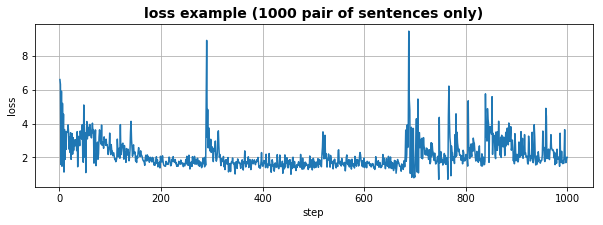

In [35]:
n_iters = 1000
training_pairs_little = [tensorsFromPair(random.choice(training_pairs_A)) for i in range(n_iters)]

losses = []
start = time.time()

for t in training_pairs_little:
    input_sen, output_sen = t    
    loss = train(input_sen,
                 output_sen,
                 encoder,
                 decoder,
                 encoder_optimizer,
                 decoder_optimizer,
                 criterion,
                 max_length=MAX_LENGTH)
    losses.append(loss)

print(timeSince(start))

simple_step_plot([losses],
                 "loss",
                 "loss example ({} pair of sentences only)".format(n_iters),
                 "loss_example.png",
                  figsize=(10,3))

In [36]:
def trainIters(encoder,
               decoder,
               n_iters,
               pairs,
               valid_pairs,
               encoder_path,
               decoder_path,
               batch_size=32,
               status_every=100,
               learning_rate=0.01,
               teacher_forcing_ratio=0.5):

    plot_losses = []
    old = 0
    start = time.time()
    all_loss = []
    valid_loss = float("inf")
    
    

    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

    for i, t in enumerate(training_pairs):
        input_sen, output_sen = t
        loss = train(input_sen,
                     output_sen,
                     encoder,
                     decoder,
                     encoder_optimizer,
                     decoder_optimizer,
                     criterion,
                     max_length=MAX_LENGTH,
                     teacher_forcing_ratio=teacher_forcing_ratio)
        plot_losses.append(loss)

        if i % status_every == 0 and i != 0:
            valid_batch = [tensorsFromPair(random.choice(valid_pairs))
                           for i in range(batch_size)]
            batch_loss = 0
            for t in valid_batch:
                input_sen, output_sen = t
                batch_loss += get_loss(input_sen,
                                       output_sen,
                                       encoder,
                                       decoder,
                                       criterion,
                                       MAX_LENGTH)
            current_valid_loss = batch_loss / batch_size
            
            if current_valid_loss < valid_loss:
                valid_loss = current_valid_loss
                torch.save(encoder.state_dict(), encoder_path)
                torch.save(decoder.state_dict(), decoder_path)
            print("mean training loss = {:.2f}".format(np.mean(plot_losses)))
            print("mean valid loss = {:.2f}".format(current_valid_loss))
            print("time in {} steps:".format(status_every), timeSince(start))
            print()
            all_loss += plot_losses
            plot_losses = []
            old = i
            start = time.time()
    
    simple_step_plot([all_loss],
                     "loss",
                     "loss over training" ,
                     "loss_example.png",
                     figsize=(15, 3))


## translating

In [37]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)

## translation of a non trained model

In [38]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = AttnDecoderRNN(hidden_size, eng_dec_v_size)

np.random.shuffle(training_pairs_A)

In [39]:
for t in training_pairs_A[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()


input_sentence : dana created a thoughtless and ambitious work of art
neural translation : lawrence martin martin martin lynn beverly beverly bessie beverly beverly bessie beverly beverly beverly bessie beverly beverly bessie beverly beverly
reference translation : dana created a thoughtless work of art <EOS>
blue score = 0.00

input_sentence : michele created a helpful and gifted work of art
neural translation : melanie sonya sonya bessie beverly beverly bessie beverly beverly bessie beverly beverly beverly bessie beverly beverly bessie beverly beverly bessie
reference translation : michele created a helpful work of art <EOS>
blue score = 0.00

input_sentence : norman created a victorious and black work of art
neural translation : melanie sonya sonya jeanne bessie beverly beverly bessie beverly beverly beverly bessie beverly beverly beverly bessie beverly beverly bessie beverly
reference translation : norman created a victorious work of art <EOS>
blue score = 0.00



## Training some models and observing its translation

In [40]:
def save_translation(pairs, encoder, decoder, max_length, out_path):
    with open(out_path, "w") as file:
        file.write("source,candidate,reference,blue,accuracy\n")        
        for tuple_ in pairs:
            source, reference = tuple_
            candidate = translate(encoder,
                                  decoder,
                                  source,
                                  max_length=max_length)
            reference =  reference + ' <EOS>'
            blue = sentence_bleu([reference.split(" ")], candidate.split(" "))
            if blue >= 0.95:
                acc = 1
            else:
                acc = 0
            line = source + ","
            line += candidate + ","
            line += reference + ","
            line += "{:.3f},".format(blue)
            line += "{}\n".format(acc)
            file.write(line)

Test save_translation

### Training 1

mean training loss = 1.81
mean valid loss = 1.47
time in 1000 steps: 0m 37s

mean training loss = 1.41
mean valid loss = 1.38
time in 1000 steps: 0m 37s

mean training loss = 1.38
mean valid loss = 1.42
time in 1000 steps: 0m 39s

mean training loss = 1.37
mean valid loss = 1.36
time in 1000 steps: 0m 39s

mean training loss = 1.38
mean valid loss = 1.36
time in 1000 steps: 0m 35s

mean training loss = 1.36
mean valid loss = 1.40
time in 1000 steps: 0m 32s

mean training loss = 1.36
mean valid loss = 1.38
time in 1000 steps: 0m 32s

mean training loss = 1.36
mean valid loss = 1.39
time in 1000 steps: 0m 32s

mean training loss = 1.36
mean valid loss = 1.35
time in 1000 steps: 0m 42s

mean training loss = 1.35
mean valid loss = 1.39
time in 1000 steps: 0m 36s

mean training loss = 1.35
mean valid loss = 1.35
time in 1000 steps: 0m 36s

mean training loss = 1.34
mean valid loss = 1.31
time in 1000 steps: 0m 40s

mean training loss = 1.27
mean valid loss = 1.26
time in 1000 steps: 0m 38s


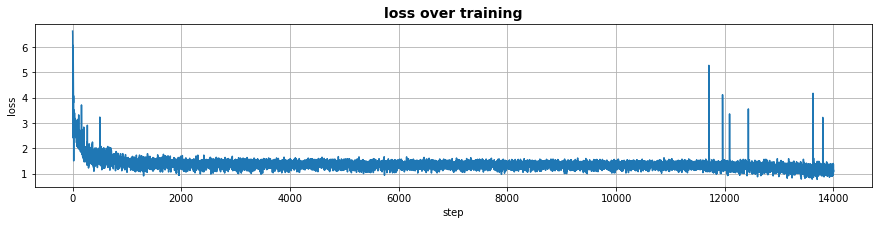

In [41]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder=encoder1,
           decoder=attn_decoder1,
           n_iters=15000,
           status_every=1000,
           pairs=training_pairs_A,
           valid_pairs=valid_pairs_A,
           encoder_path="b5_encoder1_att.pkl",
           decoder_path="b5_decoder1_att.pkl")

mean training loss = 1.83
mean valid loss = 1.64
time in 1000 steps: 0m 38s

mean training loss = 1.52
mean valid loss = 1.50
time in 1000 steps: 0m 39s

mean training loss = 1.50
mean valid loss = 1.51
time in 1000 steps: 0m 39s

mean training loss = 1.49
mean valid loss = 1.44
time in 1000 steps: 0m 43s

mean training loss = 1.47
mean valid loss = 1.51
time in 1000 steps: 0m 43s

mean training loss = 1.47
mean valid loss = 1.48
time in 1000 steps: 0m 41s

mean training loss = 1.39
mean valid loss = 1.30
time in 1000 steps: 0m 36s

mean training loss = 1.29
mean valid loss = 1.20
time in 1000 steps: 0m 42s

mean training loss = 1.10
mean valid loss = 0.93
time in 1000 steps: 0m 44s

mean training loss = 0.88
mean valid loss = 0.85
time in 1000 steps: 0m 41s

mean training loss = 0.83
mean valid loss = 0.83
time in 1000 steps: 0m 40s

mean training loss = 0.83
mean valid loss = 0.83
time in 1000 steps: 0m 45s

mean training loss = 0.82
mean valid loss = 0.82
time in 1000 steps: 0m 42s


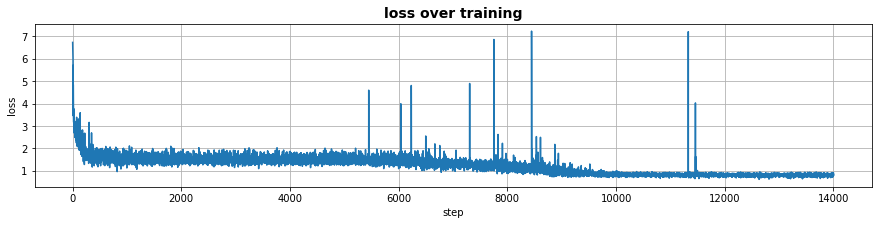

In [42]:
hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.13).to(device)

trainIters(encoder=encoder2,
           decoder=attn_decoder2,
           n_iters=15000,
           status_every=1000,
           pairs=training_pairs_B,
           valid_pairs=valid_pairs_B,
           encoder_path="b5_encoder2_att.pkl",
           decoder_path="b5_decoder2_att.pkl")

## Evaluation functions

In [43]:
save_translation(training_pairs_A,
                 encoder1,
                 attn_decoder1,
                 MAX_LENGTH,
                 "b5_training1_att.csv")

df_results = pd.read_csv("b5_training1_att.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

mean blue score over training data = 0.826
mean acc over training data = 0.003


In [44]:
save_translation(valid_pairs_A,
                 encoder1,
                 attn_decoder1,
                 MAX_LENGTH,
                 "b5_valid1_att.csv")

df_results = pd.read_csv("b5_valid1_att.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over valid data = {:.3f}".format(blue))
print("mean acc over valid data = {:.3f}".format(acc))

mean blue score over valid data = 0.822
mean acc over valid data = 0.005


In [45]:
save_translation(training_pairs_B,
                 encoder2,
                 attn_decoder2,
                 MAX_LENGTH,
                 "b5_training2_att.csv")

df_results = pd.read_csv("b5_training2_att.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

mean blue score over training data = 0.842
mean acc over training data = 0.005


In [46]:
save_translation(valid_pairs_B,
                 encoder2,
                 attn_decoder2,
                 MAX_LENGTH,
                 "b5_valid2_att.csv")

df_results = pd.read_csv("b5_valid2_att.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over valid data = {:.3f}".format(blue))
print("mean acc over valid data = {:.3f}".format(acc))

mean blue score over valid data = 0.841
mean acc over valid data = 0.003


In [47]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [48]:
output_words, attentions = evaluate(encoder1,
                                    attn_decoder1,
                                    'joshua created a jolly and black work of art')

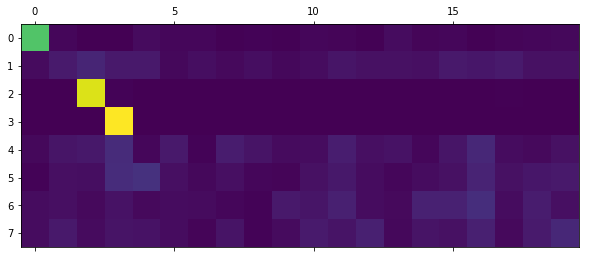

In [49]:
plt.matshow(attentions.numpy())

In [50]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


input = joshua created a jolly and black work of art
output = jamie created a jolly work of art <EOS>


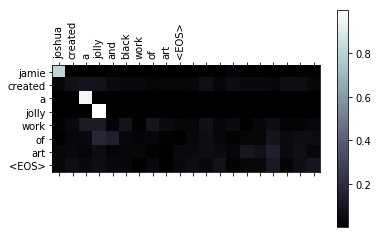

In [51]:
evaluateAndShowAttention('joshua created a jolly and black work of art')